In [1]:
import numpy as np
import pandas as pd
import os

# Visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
!pip install pycountry
import pycountry
import plotly.express as px
from plotly.offline import init_notebook_mode, download_plotlyjs, plot, iplot
import plotly.graph_objs as go
import plotly.offline as py
!pip install chart_studio
import chart_studio.plotly as py
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

# Geographical Plotting
import folium
from folium import Choropleth, Circle, Marker
from folium import plugins
from folium.plugins import HeatMap, MarkerCluster

# Racing Bar Chart
!pip install bar_chart_race
import bar_chart_race as bcr
from IPython.display import HTML

# Increase the default plot size and set the color scheme
plt.rcParams['figure.figsize'] = 8, 5
plt.style.use('fivethirtyeight')

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 62.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 3.0 MB/s eta 0:00:00


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 5.2 MB/s eta 0:00:00
/kaggle/input/air-quality-data-in-india/stations.csv
/kaggle/input/air-quality-data-in-india/station_hour.csv
/kaggle/input/air-quality-data-in-india/city_day.csv
/kaggle/input/air-quality-data-in-india/city_hour.csv
/kaggle/input/air-quality-data-in-india/station_day.csv
/kaggle/input/indian-cities-database/Indian Cities Database.csv


In [2]:
city_day = pd.read_csv('/kaggle/input/air-quality-data-in-india/city_day.csv')
cities_db = pd.read_csv('/kaggle/input/indian-cities-database/Indian Cities Database.csv')

In [3]:
cities_db.head()

,City,Lat,Long,country,iso2,State
0,Abohar,30.144533,74.195520,India,IN,Punjab
1,Adilabad,19.400000,78.310000,India,IN,Telangana
2,Agartala,23.836049,91.279386,India,IN,Tripura
3,Agra,27.187935,78.003944,India,IN,Uttar Pradesh
4,Ahmadnagar,19.094571,74.738432,India,IN,Maharashtra


## 1. A first look at the data

In [4]:
display('CITY DAILY DATA')
display(city_day.head(5))

'CITY DAILY DATA'

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [5]:
city_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        29531 non-null  object 
 1   Date        29531 non-null  object 
 2   PM2.5       24933 non-null  float64
 3   PM10        18391 non-null  float64
 4   NO          25949 non-null  float64
 5   NO2         25946 non-null  float64
 6   NOx         25346 non-null  float64
 7   NH3         19203 non-null  float64
 8   CO          27472 non-null  float64
 9   SO2         25677 non-null  float64
 10  O3          25509 non-null  float64
 11  Benzene     23908 non-null  float64
 12  Toluene     21490 non-null  float64
 13  Xylene      11422 non-null  float64
 14  AQI         24850 non-null  float64
 15  AQI_Bucket  24850 non-null  object 
dtypes: float64(13), object(3)
memory usage: 3.6+ MB


### 1.1 Missing Values

In [6]:
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()
    
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing Values',
                 1: '% of Total Values'}
    )
    
    
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values('% of Total Values', ascending=False).round(1)
    
    # Print some summary information
    print('Your selected dataframe has ' + str(df.shape[1]) + ' columns.\n' + 'There are ' + str(mis_val_table_ren_columns.shape[0]) + ' columns that have missing values.')
    
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [7]:
missing_values = missing_values_table(city_day)
missing_values.style.background_gradient(cmap='Reds')

Your selected dataframe has 16 columns.
There are 14 columns that have missing values.


,Missing Values,% of Total Values
Xylene,18109,61.300000
PM10,11140,37.700000
NH3,10328,35.000000
Toluene,8041,27.200000
Benzene,5623,19.000000
AQI,4681,15.900000
AQI_Bucket,4681,15.900000
PM2.5,4598,15.600000
NOx,4185,14.200000
O3,4022,13.600000


### 1.2 Cities in the Dataset

In [8]:
cities = city_day['City'].value_counts()
print(f'Total number of cities in the dataset: {len(cities)}')
print(cities.index)

Total number of cities in the dataset: 26
Index(['Ahmedabad', 'Delhi', 'Mumbai', 'Bengaluru', 'Lucknow', 'Chennai',
       'Hyderabad', 'Patna', 'Gurugram', 'Visakhapatnam', 'Amritsar',
       'Jorapokhar', 'Jaipur', 'Thiruvananthapuram', 'Amaravati',
       'Brajrajnagar', 'Talcher', 'Kolkata', 'Guwahati', 'Coimbatore',
       'Shillong', 'Chandigarh', 'Bhopal', 'Ernakulam', 'Kochi', 'Aizawl'],
      dtype='object', name='City')


### 1.3 Convert to Date Time format

In [9]:
# Convert string to datetime64
city_day['Date'] = pd.to_datetime(city_day['Date'])

### 1.4 Data Availability

In [10]:
print(f'The available data is between {city_day["Date"].min()} and {city_day["Date"].max()}')

The available data is between 2015-01-01 00:00:00 and 2020-07-01 00:00:00


## 2. Analysing the complete city level daily data

### 2.1 Combining the Benzene, Toluene and Xylene levels into one column - BTX

In [11]:
city_day['BTX'] = city_day['Benzene'] + city_day['Toluene'] + city_day['Xylene']
city_day = city_day.drop(['Benzene', 'Toluene', 'Xylene'], axis=1)

In [12]:
city_day

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,AQI,AQI_Bucket,BTX
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,NaN,NaN,0.02
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,NaN,NaN,12.95
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,NaN,NaN,25.45
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,NaN,NaN,15.57
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,NaN,NaN,28.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29526,Visakhapatnam,2020-06-27,15.02,50.94,7.68,25.06,19.54,12.47,0.47,8.55,23.30,41.0,Good,15.04
29527,Visakhapatnam,2020-06-28,24.38,74.09,3.42,26.06,16.53,11.99,0.52,12.72,30.14,70.0,Satisfactory,3.33
29528,Visakhapatnam,2020-06-29,22.91,65.73,3.45,29.53,18.33,10.71,0.48,8.42,30.96,68.0,Satisfactory,0.02
29529,Visakhapatnam,2020-06-30,16.64,49.97,4.05,29.26,18.80,10.03,0.52,9.84,28.30,54.0,Satisfactory,0.00


### 2.2 Combining the PM2.5 AND PM10 into one column - Particulate_Matter

In [13]:
city_day['Particulate_Matter'] = city_day['PM2.5'] + city_day['PM10']

### 2.3 Subsetting columns

Even though a lot of columns have been provided in the dataset, we shall select a few prominent ones. Let's create a new dataframe called `pollutants` containing the major pollutants responsible for air poluution.

In [14]:
pollutants = ['PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3', 'BTX']

### 2.3 Visualizing yearly data

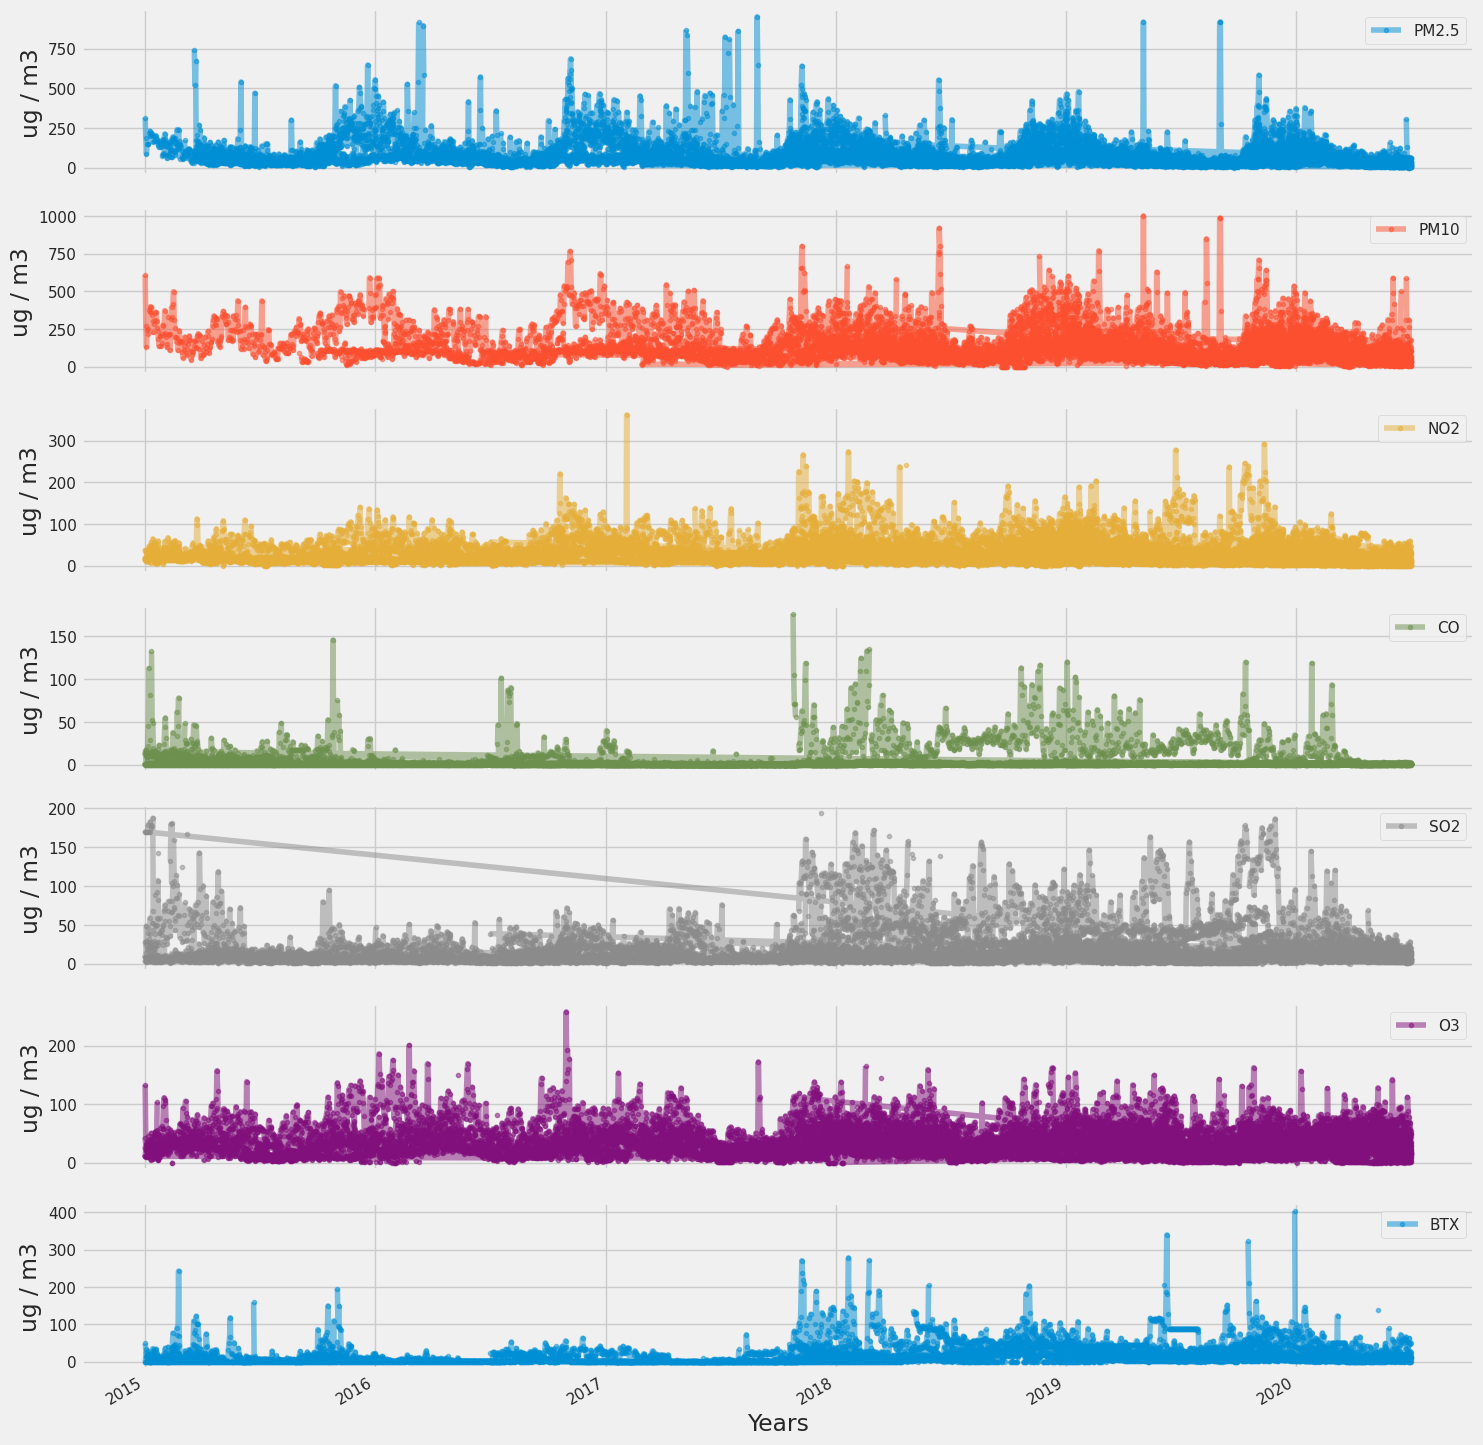

In [15]:
city_day.set_index('Date', inplace=True)
axes = city_day[pollutants].plot(marker='.',
                                 alpha=0.5, 
                                 linestyle=None,
                                 figsize=(16, 20), 
                                 subplots=True)

for ax in axes:
    ax.set_xlabel('Years')
    ax.set_ylabel('ug / m3')

Points to note:
* PM2.5 and PM10 pollution show a seasonal effect, with pollution being higher in winter months as compared to summer ones.
* SO2 level has started increasing after 2017, although it had also seen a sudden rise in 2015 also. The same pattern is seen in BTX levels as well.

### 2.4 Year and Month wise distribution

Let's further explore the seasonality of our data with box plots. We shall use boxplots to group the data by different time periods and display the distributions for each group. We will group the data by year and month. All measurements are in `ug / m3`.

In [16]:
def trend_plot(df, value):
    # Prepare data
    df['year'] = [d.year for d in df.Date]
    df['month'] = [d.strftime('%b') for d in df.Date]
    years = df['year'].unique()

    # Draw plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=80)
    sns.boxplot(x='year', y=value, data=df, ax=axes[0])
    
    sns.pointplot(x='month', y=value, data=df.loc[~df.year.isin([2015, 2020]), :], ax=axes[1])
    
    # Set title
    axes[0].set_title('Year-wise Box Plot \n(The Trend)', fontsize=18)
    axes[1].set_title('Month-wise Plot \n(The Seasonality)', fontsize=18)
    plt.show()


#### 2.4.1 NO2

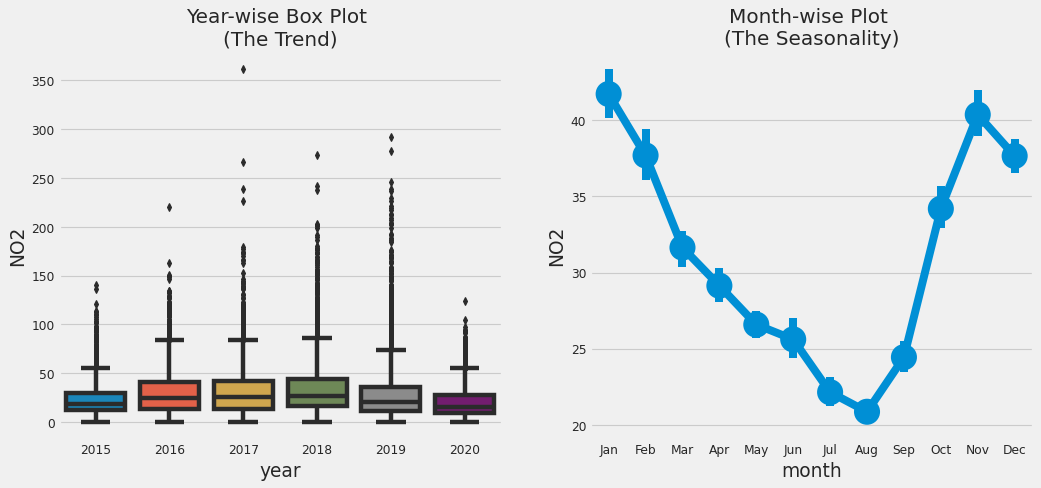

In [17]:
city_day.reset_index(inplace=True)
df = city_day.copy()
value = 'NO2'
trend_plot(df, value)

#### 2.4.2 SO2

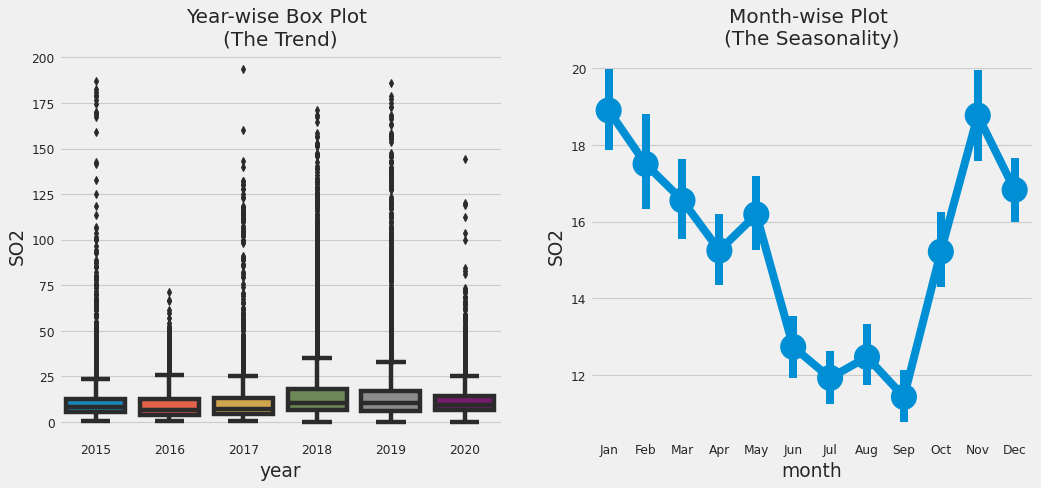

In [18]:
# city_day.reset_index(inplace=True)
df = city_day.copy()
value = 'SO2'
trend_plot(df, value)

#### 2.4.3 BTX

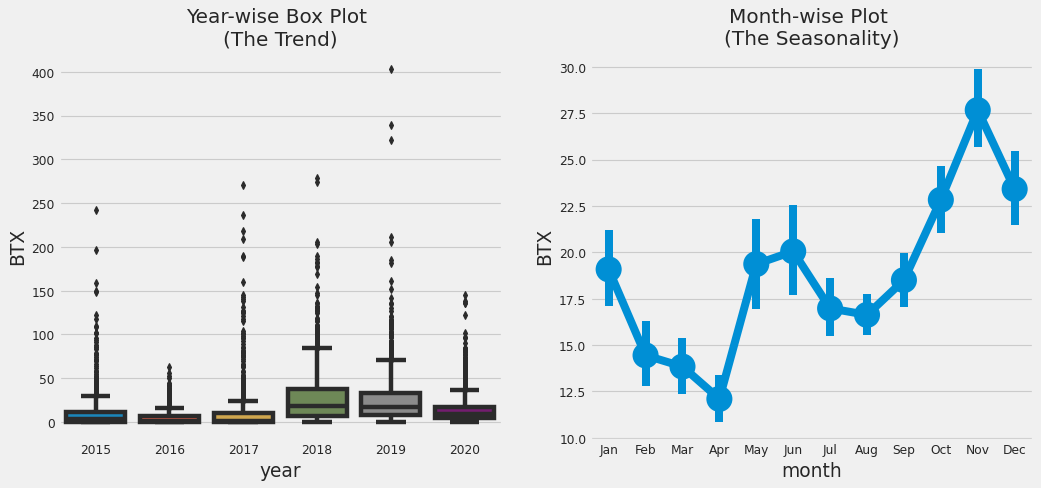

In [19]:
value = 'BTX'
trend_plot(df, value)

#### 2.4.4 PM2.5

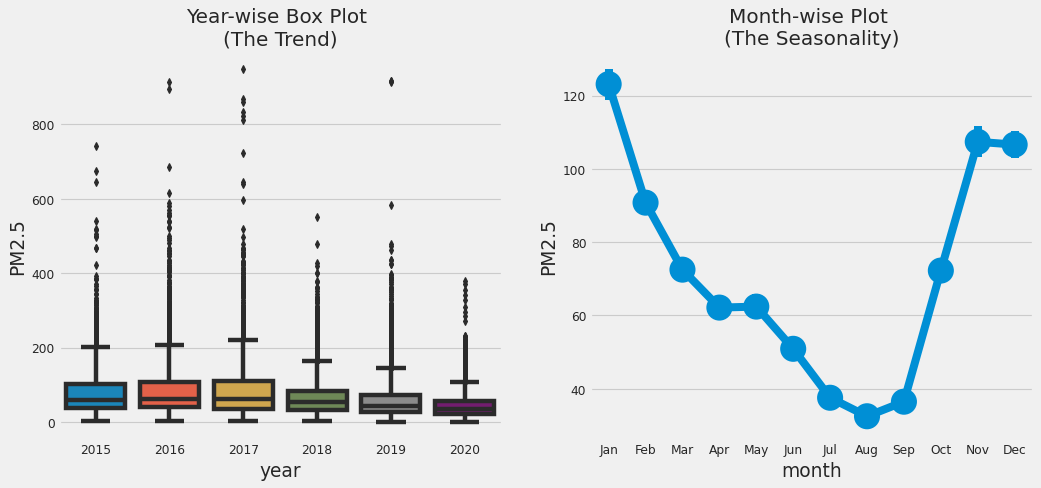

In [20]:
value = 'PM2.5'
trend_plot(df, value)

#### 2.4.5 PM10

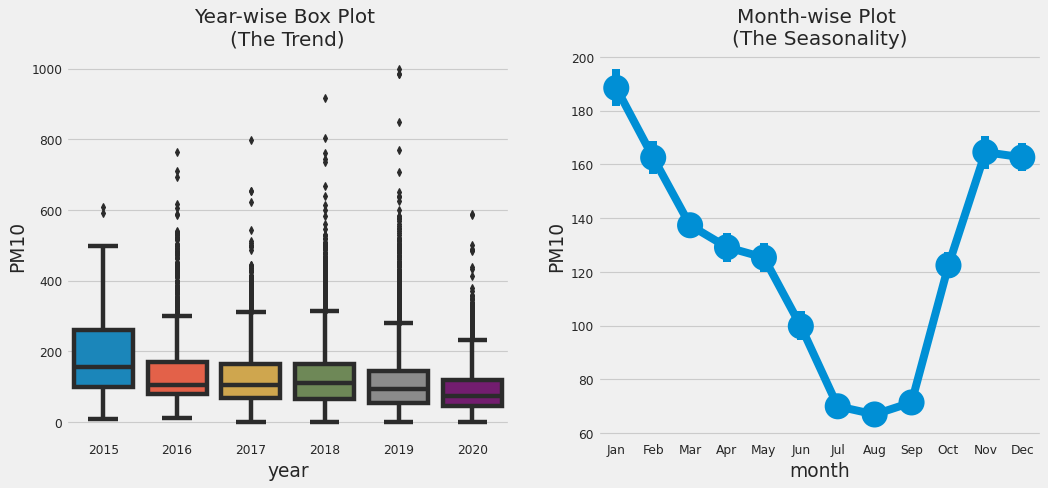

In [21]:
value = 'PM10'
trend_plot(df, value)

## 3. Most Polluted Indian Cities

Let's look at the Indian cities which contribute to maximum pollution. We shall output the top 10 cities in each pollutant category by mean concentration.

In [22]:
def max_polluted_city(pollutant, top_n=10):
    x1 = city_day[[pollutant, 'City']].groupby('City').mean().sort_values(by=pollutant, ascending=False)
    x1[pollutant] = round(x1[pollutant], 2)
    
    return x1[:top_n].style.background_gradient(cmap='OrRd')

In [23]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [24]:
pm2_5 = max_polluted_city('PM2.5')
pm10 = max_polluted_city('PM10')
no2 = max_polluted_city('NO2')
so2 = max_polluted_city('SO2')
co = max_polluted_city('CO')
btx = max_polluted_city('BTX')

display_side_by_side(pm2_5, pm10, no2, so2, co, btx)

,PM2.5
City,
Patna,123.500000
Delhi,117.200000
Gurugram,117.100000
Lucknow,109.710000
Ahmedabad,67.850000
Kolkata,64.360000
Jorapokhar,64.230000
Brajrajnagar,64.060000
Guwahati,63.690000


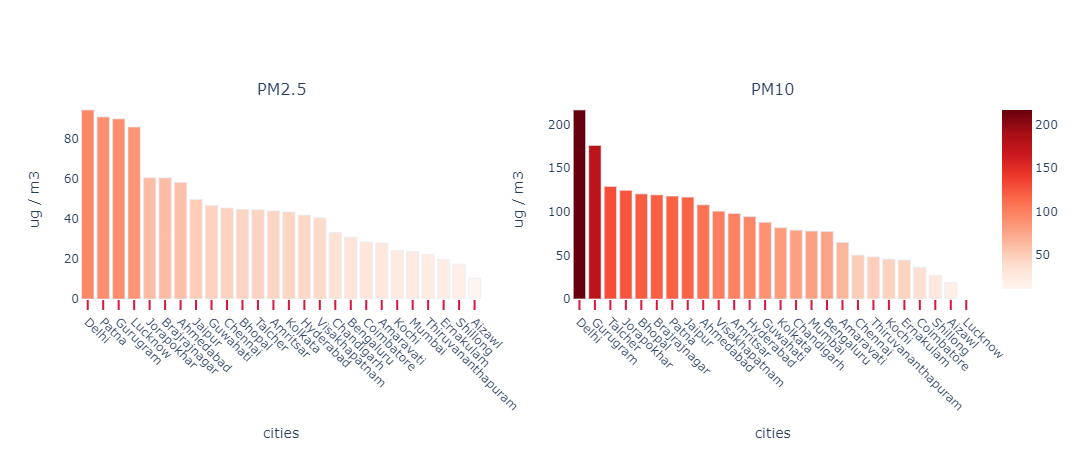

In [25]:

x2= city_day[['PM2.5','City']].groupby(["City"]).median().sort_values(by='PM2.5',ascending=False).reset_index()
x3 = city_day[['PM10','City']].groupby(["City"]).median().sort_values(by='PM10',ascending=False).reset_index()

from plotly.subplots import make_subplots
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("PM2.5","PM10"))

fig.add_trace(go.Bar( y=x2['PM2.5'], x=x2["City"],  
                     marker=dict(color=x2['PM2.5'], coloraxis="coloraxis")),
              1, 1)


fig.add_trace(go.Bar( y=x3['PM10'], x=x3["City"],  
                     marker=dict(color=x3['PM10'], coloraxis="coloraxis")),
              1, 2)
fig.update_layout(coloraxis=dict(colorscale='reds'), showlegend=False,plot_bgcolor='white')
fig.update_xaxes(ticks="outside", tickwidth=2,tickangle=45, tickcolor='crimson', ticklen=10,title_text="cities")
fig.update_yaxes(title_text="ug / m3", row=1, col=1)
fig.update_yaxes(title_text="ug / m3", row=1, col=2)
fig.show()

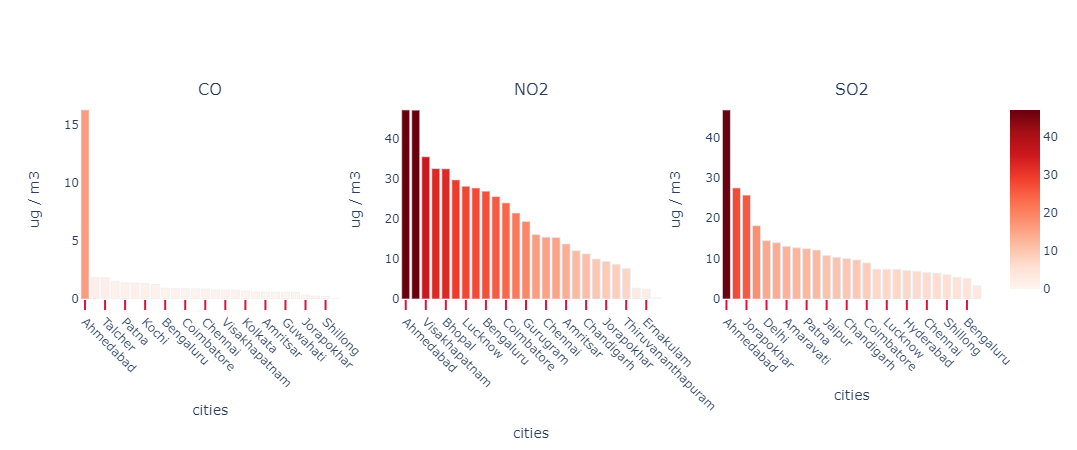

In [26]:
x4 = city_day[['CO', 'City']].groupby(['City']).median().sort_values(by='CO', ascending=False).reset_index()
x5 = city_day[['NO2', 'City']].groupby(['City']).median().sort_values(by='NO2', ascending=False).reset_index()
x6 = city_day[['SO2', 'City']].groupby(['City']).median().sort_values(by='SO2', ascending=False).reset_index()

from plotly.subplots import make_subplots
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=('CO', 'NO2', 'SO2')
) 
fig.add_trace(go.Bar(y=x4['CO'], x=x4['City'],
                     marker=dict(color=x4['CO'], coloraxis='coloraxis')),
              1, 1)
fig.add_trace(go.Bar(y=x5['NO2'], x=x5['City'],
                     marker=dict(color=x5['NO2'], coloraxis='coloraxis')),
              1, 2)
fig.add_trace(go.Bar(y=x6['SO2'], x=x6['City'],
                     marker=dict(color=x6['SO2'], coloraxis='coloraxis')),
              1, 3)
fig.update_layout(coloraxis=dict(colorscale='reds'), showlegend=False, plot_bgcolor='white')
fig.update_xaxes(ticks='outside', tickwidth=2, tickangle=45, tickcolor='crimson', ticklen=10, title_text='cities')
fig.update_yaxes(title_text='ug / m3', row=1, col=1)
fig.update_yaxes(title_text='ug / m3', row=1, col=2)
fig.update_yaxes(title_text='ug / m3', row=1, col=3)
fig.show()

## 4. Effect of Lockdown on AQI
Let's now see how the lockdown affected the AQI levels in the prominent cities of India. For this we shall consider the data from 2019 onwards only. Before that, let's understand what AQI is:
### 4.1 AQI : Air Quality Index
An air quality index (AQI) is used by government agencies to communicate to the public how polluted the air currently is or how polluted it is forecast to become.There are six AQI categories, namely Good, Satisfactory, Moderately polluted, Poor, Very Poor, and Severe. The proposed AQI will consider eight pollutants (PM10, PM2.5, NO2, SO2, CO, O3, NH3, and Pb) for which short-term (up to 24-hourly averaging period)

### 4.2 AQI for some major Indian cities

In [27]:
cities = ['Ahmedabad', 'Delhi', 'Bengaluru', 'Mumbai', 'Hyderabad', 'Chennai']

filtered_city_day = city_day[city_day['Date'] >= '2019-01-01']
AQI = filtered_city_day[filtered_city_day.City.isin(cities)][['Date', 'City', 'AQI', 'AQI_Bucket']]
AQI.head()

,Date,City,AQI,AQI_Bucket
1461,2019-01-01,Ahmedabad,1474.0,Severe
1462,2019-01-02,Ahmedabad,1246.0,Severe
1463,2019-01-03,Ahmedabad,1719.0,Severe
1464,2019-01-04,Ahmedabad,1264.0,Severe
1465,2019-01-05,Ahmedabad,1127.0,Severe


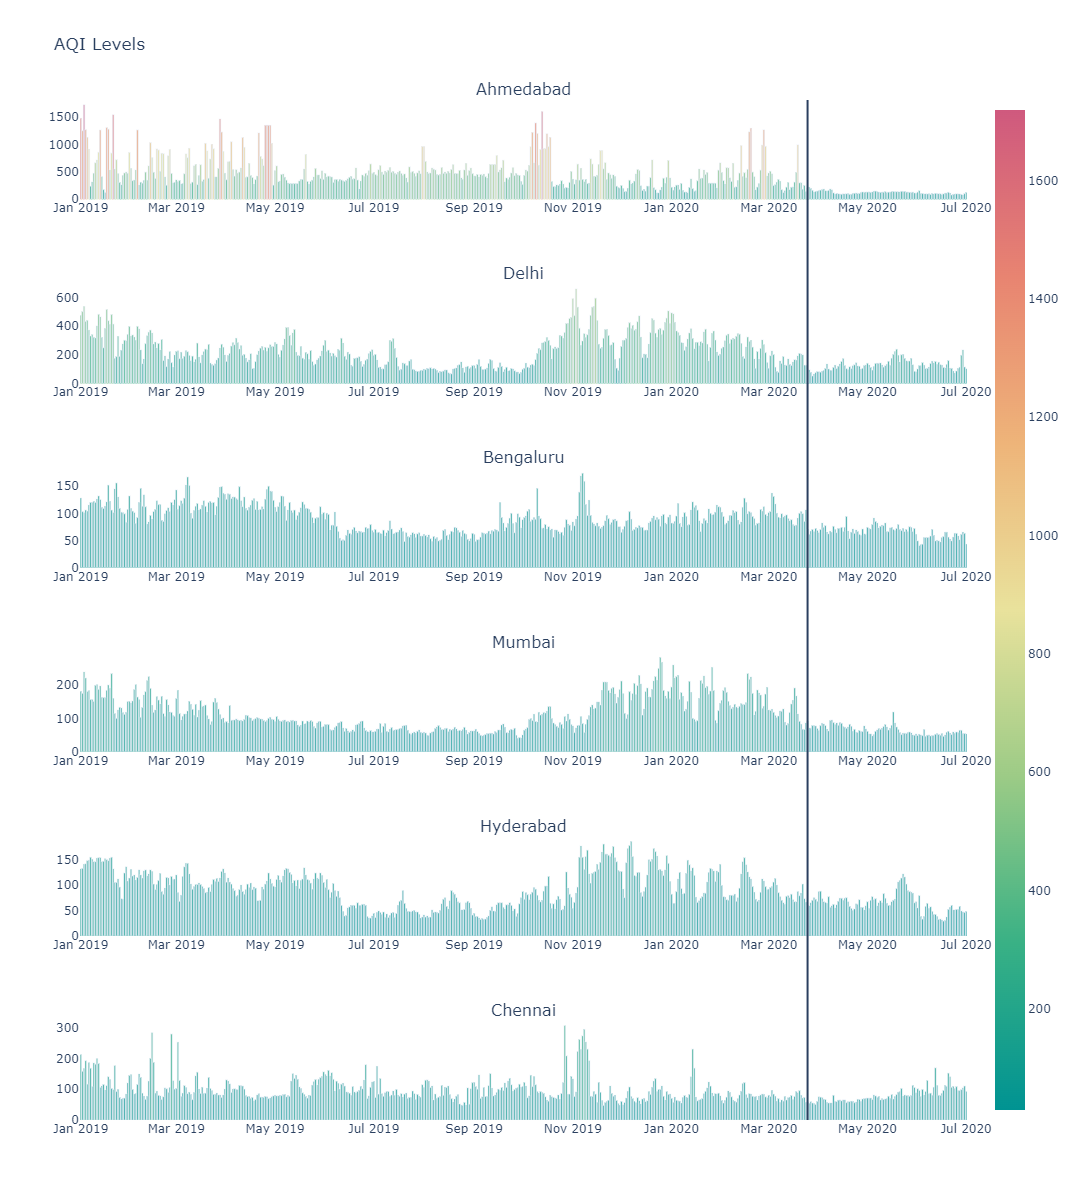

In [28]:
AQI_pivot = AQI.pivot(index='Date', columns='City', values='AQI')
AQI_pivot = AQI_pivot.fillna(method='bfill')

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=6, cols=1,
    subplot_titles=tuple(cities)
)

for i, city in enumerate(cities):
    fig.add_trace(go.Bar(x=AQI_pivot.index, y=AQI_pivot[city],
                         marker=dict(color=AQI_pivot[city], coloraxis='coloraxis')),
                  row=i+1, col=1)  
fig.update_layout(coloraxis=dict(colorscale='Temps'), showlegend=False, title_text='AQI Levels')
fig.update_layout(plot_bgcolor='white')
fig.update_layout(width=800, height=1200, shapes=[
    dict(
        type='line',
        yref='paper',
        y0=0, y1=1,
        xref='x', x0='2020-03-25', x1='2020-03-25'
    )
])
fig.show()

### 4.3 AQI in 2020
Let's plot a racing bar chart to see the overall AQI in 2020

In [30]:
import bar_chart_race as bcr
from IPython.display import HTML

# Filter data for the year 2020
AQI_2020 = AQI_pivot[AQI_pivot.index > '2019-12-31']

# Save the bar chart race as a video (for example, as an mp4 file)
bcr.bar_chart_race(df=AQI_2020, filename='AQI_2020.mp4', period_length=300, orientation='v', figsize=(8, 6), bar_label_size=7, tick_label_size=7, title='AQI levels in 2020')

# Display the saved video in Jupyter notebook
HTML("""
<video width="640" height="480" controls>
  <source src="AQI_2020.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")
